PPP (with BM3D) CT Reconstruction (ADMM with CG Subproblem Solver)
==================================================================

This example demonstrates solution of a tomographic reconstruction problem
using the Plug-and-Play Priors framework
<cite data-cite="venkatakrishnan-2013-plugandplay2"/>, using BM3D
<cite data-cite="dabov-2008-image"/> as a denoiser and SVMBIR <cite data-cite="svmbir-2020"/> for
tomographic projection.

There are two versions of this example, solving the same problem in two
different ways.  This version uses the data fidelity term as the ADMM $f$,
and thus the optimization with respect to the data fidelity uses CG rather
than the prox of the `SVMBIRSquaredL2Loss` functional, as in the
[other version](ct_svmbir_ppp_bm3d_admm_prox.rst).

In [1]:
import numpy as np

import jax

import matplotlib.pyplot as plt
import svmbir
from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import metric, plot
from scico.functional import BM3D, NonNegativeIndicator
from scico.linop import Diagonal, Identity
from scico.linop.radon_svmbir import SVMBIRSquaredL2Loss, TomographicProjector
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Generate a ground truth image.

In [2]:
N = 256  # image size
density = 0.025  # attenuation density of the image
np.random.seed(1234)
x_gt = discrete_phantom(Foam(size_range=[0.05, 0.02], gap=0.02, porosity=0.3), size=N - 10)
x_gt = x_gt / np.max(x_gt) * density
x_gt = np.pad(x_gt, 5)
x_gt[x_gt < 0] = 0

Generate tomographic projector and sinogram.

In [3]:
num_angles = int(N / 2)
num_channels = N
angles = snp.linspace(0, snp.pi, num_angles, endpoint=False, dtype=snp.float32)
A = TomographicProjector(x_gt.shape, angles, num_channels)
sino = A @ x_gt

Impose Poisson noise on sinogram. Higher max_intensity means less noise.

In [4]:
max_intensity = 2000
expected_counts = max_intensity * np.exp(-sino)
noisy_counts = np.random.poisson(expected_counts).astype(np.float32)
noisy_counts[noisy_counts == 0] = 1  # deal with 0s
y = -np.log(noisy_counts / max_intensity)

Reconstruct using default prior of SVMBIR <cite data-cite="svmbir-2020"/>.

In [5]:
weights = svmbir.calc_weights(y, weight_type="transmission")

x_mrf = svmbir.recon(
    np.array(y[:, np.newaxis]),
    np.array(angles),
    weights=weights[:, np.newaxis],
    num_rows=N,
    num_cols=N,
    positivity=True,
    verbose=0,
)[0]

Set up an ADMM solver.

In [6]:
y, x0, weights = jax.device_put([y, x_mrf, weights])

ρ = 15  # ADMM penalty parameter
σ = density * 0.18  # denoiser sigma

f = SVMBIRSquaredL2Loss(y=y, A=A, W=Diagonal(weights), scale=0.5)
g0 = σ * ρ * BM3D()
g1 = NonNegativeIndicator()

solver = ADMM(
    f=f,
    g_list=[g0, g1],
    C_list=[Identity(x_mrf.shape), Identity(x_mrf.shape)],
    rho_list=[ρ, ρ],
    x0=x0,
    maxiter=20,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-4, "maxiter": 100}),
    itstat_options={"display": True, "period": 1},
)

Run the solver.

In [7]:
print(f"Solving on {device_info()}\n")
x_bm3d = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Prml Rsdl  Dual Rsdl  CG It  CG Res   
------------------------------------------------------
   0  1.24e+01  4.146e-01  3.195e-01     17  8.075e-05


   1  2.22e+01  1.820e-01  2.382e-01     13  9.809e-05


   2  3.24e+01  8.771e-02  1.455e-01     13  6.297e-05


   3  4.11e+01  7.198e-02  8.450e-02     11  8.374e-05


   4  4.95e+01  6.273e-02  5.044e-02     10  7.179e-05


   5  5.68e+01  4.450e-02  4.233e-02      8  8.889e-05


   6  6.37e+01  3.022e-02  3.718e-02      7  9.427e-05


   7  7.03e+01  2.530e-02  2.881e-02      7  7.471e-05


   8  7.74e+01  2.327e-02  2.223e-02      6  7.747e-05


   9  8.39e+01  2.036e-02  1.901e-02      6  8.175e-05


  10  9.06e+01  1.786e-02  1.673e-02      6  7.804e-05


  11  9.64e+01  1.653e-02  1.499e-02      5  9.602e-05


  12  1.03e+02  1.536e-02  1.378e-02      6  8.007e-05


  13  1.09e+02  1.422e-02  1.228e-02      5  8.644e-05


  14  1.14e+02  1.357e-02  1.155e-02      5  7.571e-05


  15  1.19e+02  1.278e-02  1.122e-02      4  8.455e-05


  16  1.25e+02  1.242e-02  1.107e-02      4  8.895e-05


  17  1.31e+02  1.171e-02  1.084e-02      4  9.207e-05


  18  1.35e+02  1.141e-02  1.070e-02      4  9.700e-05


  19  1.40e+02  1.113e-02  1.108e-02      3  9.702e-05


Show the recovered image.

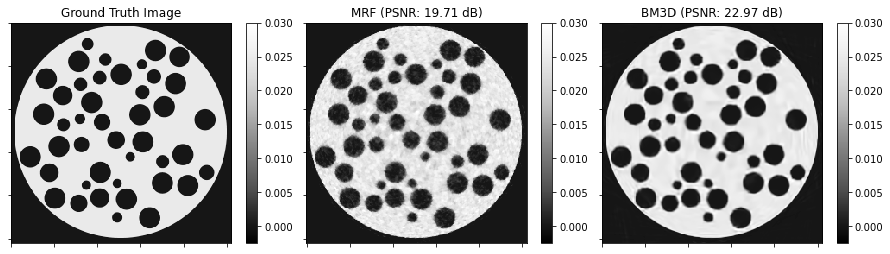

In [8]:
norm = plot.matplotlib.colors.Normalize(vmin=-0.1 * density, vmax=1.2 * density)
fig, ax = plt.subplots(1, 3, figsize=[15, 5])
plot.imview(img=x_gt, title="Ground Truth Image", cbar=True, fig=fig, ax=ax[0], norm=norm)
plot.imview(
    img=x_mrf,
    title=f"MRF (PSNR: {metric.psnr(x_gt, x_mrf):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[1],
    norm=norm,
)
plot.imview(
    img=x_bm3d,
    title=f"BM3D (PSNR: {metric.psnr(x_gt, x_bm3d):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[2],
    norm=norm,
)
fig.show()

Plot convergence statistics.

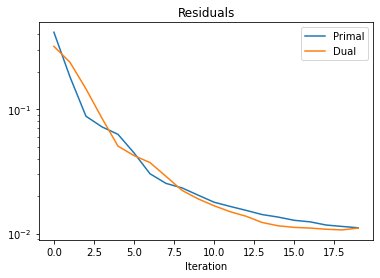

In [9]:
plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
)